## Importing Libraries

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the dataset

In [219]:
dataset = pd.read_csv("CO2 Emissions_Canada.csv")

## Data cleaning and engeenering

In [220]:
non_informative_columns = ["Make", "Model"]
redundant_columns = ["Fuel Consumption Comb (L/100 km)", "Fuel Consumption Comb (mpg)"]
# The producer can't know fuel consumption in advance.
# It can only be mesured after the car is built.
leakage_variables = ["Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)"]
columns_to_drop = non_informative_columns + redundant_columns + leakage_variables
dataset.drop(columns=columns_to_drop, inplace=True)
dataset.isna().sum()

Vehicle Class          0
Engine Size(L)         0
Cylinders              0
Transmission           0
Fuel Type              0
CO2 Emissions(g/km)    0
dtype: int64

## Features and Target division

In [221]:
y = dataset["CO2 Emissions(g/km)"]
X = dataset.drop("CO2 Emissions(g/km)", axis=1)

## Transforming categorical data into numerical columns

In [222]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# ct = ColumnTransformer(
#     transformers=[("encoder", OneHotEncoder(drop='first'), ["Vehicle Class", "Transmission", "Fuel Type"])], remainder="passthrough"
# )
# X = ct.fit_transform(X).toarray()



## Splitting the data into Train and Test sets

In [223]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

## Features Scaling

In [224]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

## Selecting an Optimal Regression Model

In [225]:
import concurrent.futures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# models_to_run = []

# for degree in range(1, 3):
#     models_to_run.append(('poly_' + str(degree), LinearRegression(), PolynomialFeatures(degree)))

# regressionModels = [SVR(),
#                     DecisionTreeRegressor(),
#                     RandomForestRegressor(),
#                     GradientBoostingRegressor(),
#                     MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=1000, random_state=42),
#                     ]
# for model in regressionModels:
#     models_to_run.append((model.__class__.__name__, model, None))

# results = []

# def train_model(name, model, poly):
#     if poly:
#         X_poly_train = poly.fit_transform(X_train)
#         X_poly_test = poly.transform(X_test)
#         model.fit(X_poly_train, y_train)
#         return (name, model, X_poly_test, poly)
#     else:
#         model.fit(X_train, y_train)
#         return (name, model, X_test, None)

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(train_model, name, model, poly) for name, model, poly in models_to_run]
#     for f in concurrent.futures.as_completed(futures):
#         results.append(f.result())

# regressions = results

## Trying different models

### Preparing column transformers for different types of models

In [226]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

categorical_cols = ["Vehicle Class", "Transmission", "Fuel Type"]
numeric_cols = X.columns.difference(categorical_cols)
ohe_transformer = ("encoder", OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
sc_transformer = ('scaler', StandardScaler(), numeric_cols)
oe_transformer = (
            "ordinal",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
            categorical_cols,
)

ct_linear_and_mlp = ColumnTransformer(
    transformers=[
        ohe_transformer,
        sc_transformer
    ],remainder="passthrough"
)

ct_tree = ColumnTransformer(
    transformers=[
        oe_transformer
    ],
    remainder="passthrough"
)

### Training the models

In [227]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

pipeline = Pipeline(
    [
        ("preprocessing", "passthrough"),
        ("poly", "passthrough"),
        ("regressor", DummyRegressor()),
    ]
)

param_grid = [
    {
        "preprocessing": [ct_linear_and_mlp],
        "poly": [
            PolynomialFeatures(degree=1, include_bias=False),
            PolynomialFeatures(degree=2, include_bias=False),
        ],
        "regressor": [LinearRegression()],
    },
    {
        "preprocessing": [ct_linear_and_mlp],
        "poly": ["passthrough"],
        "regressor": [SVR()],
    },
    {
        "preprocessing": [ct_tree],
        "poly": ["passthrough"],
        "regressor": [
            DecisionTreeRegressor(random_state=23),
            RandomForestRegressor(random_state=23),
            GradientBoostingRegressor(random_state=23),
        ],
    },
    {
        "preprocessing": [ct_linear_and_mlp],
        "poly": ["passthrough"],
        "regressor": [MLPRegressor(max_iter=1000, random_state=42, early_stopping=True)],
        "regressor__hidden_layer_sizes": [
            (100,),
            (100, 100),
            (110, 110),
            (90, 90),
            (120, 120),
        ],
        "regressor__activation": [
            "relu",
            "tanh"
            ],
        "regressor__alpha": [0.0001, 0.001],
    },
]

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

In [228]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categorie

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing', 'passthrough'),
                                       ('poly', 'passthrough'),
                                       ('regressor', DummyRegressor())]),
             n_jobs=-1,
             param_grid=[{'poly': [PolynomialFeatures(degree=1,
                                                      include_bias=False),
                                   PolynomialFeatures(include_bias=False)],
                          'preprocessing': [ColumnTransformer(remainder='passthrough',
                                                              transformers=[('encoder',
                                                                             OneHotEncoder(d...
                                                                              'Fuel '
                                                                              'Type']),
                                                                            ('scaler',
                                                                             StandardScaler(),
                                                                             Index(['Cylinders', 'Engine Size(L)'], dtype='object'))])],
                          'regressor': [MLPRegressor(early_stopping=True,
                                                     max_iter=1000,
                                                     random_state=42)],
                          'regressor__activation': ['relu', 'tanh'],
                          'regressor__alpha': [0.0001, 0.001],
                          'regressor__hidden_layer_sizes': [(100,), (100, 100),
                                                            (110, 110),
                                                            (90, 90),
                                                            (120, 120)]}],
             scoring='r2', verbose=1)

## Models comparison

### Evaluating the models by $ \mathbb{R}^ 2 $ score

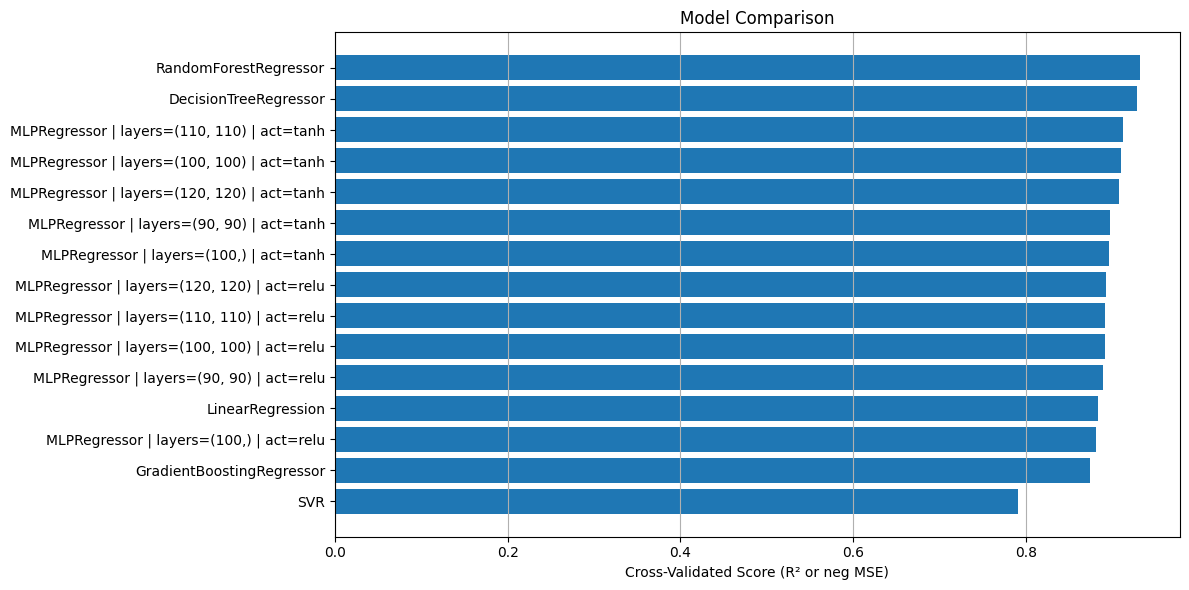

In [229]:
import numpy as np
import matplotlib.pyplot as plt

# Get cv_results_ from your completed GridSearchCV
results = grid.cv_results_

# Extract mean scores and parameter sets
r2_scores = results['mean_test_score']
params = results['params']

# Build human-readable labels for each run
model_labels = []
for p in params:
    model = type(p['regressor']).__name__
    label_parts = [model]

    # Add key hyperparameters to label if present
    if 'regressor__kernel' in p:
        label_parts.append(f"kernel={p['regressor__kernel']}")
    if 'regressor__hidden_layer_sizes' in p:
        label_parts.append(f"layers={p['regressor__hidden_layer_sizes']}")
    if 'regressor__activation' in p:
        label_parts.append(f"act={p['regressor__activation']}")
    if 'poly__degree' in p:
        label_parts.append(f"poly={p['poly__degree']}")
    if 'regressor__max_depth' in p and p['regressor__max_depth'] is not None:
        label_parts.append(f"depth={p['regressor__max_depth']}")

    model_labels.append(" | ".join(label_parts))

# Sort results by score
sorted_indices = np.argsort(r2_scores)[::-1]
sorted_scores = r2_scores[sorted_indices]
sorted_labels = np.array(model_labels)[sorted_indices]

# Plot
plt.figure(figsize=(12, 6))
plt.barh(sorted_labels, sorted_scores)
plt.xlabel("Cross-Validated Score (R² or neg MSE)")
plt.title("Model Comparison")
plt.gca().invert_yaxis()  # Best on top
plt.tight_layout()
plt.grid(axis="x")
plt.show()

### Selecting the best One

In [230]:
best_pipeline = grid.best_estimator_
best_model = best_pipeline.named_steps['regressor']
model_name = type(best_model).__name__

print(model_name)

hyperparams = ""
is_poly = 'poly' in best_pipeline.named_steps
if is_poly:
    poly_step = best_pipeline.named_steps['poly']
    if hasattr(poly_step, 'degree'):
        hyperparams = f"(poly_degree={poly_step.degree})"


print(
    f"The top-performing model is {model_name}{hyperparams if is_poly else ''}\n"
    f"with an accuracy (cross-validated R^2 score) of {grid.best_score_:.4f}."
)

RandomForestRegressor
The top-performing model is RandomForestRegressor
with an accuracy (cross-validated R^2 score) of 0.9315.


## Test Prediction for a Single Instance

In [231]:
vehicle_prototype_instance = pd.DataFrame([{
'Vehicle Class': "COMPACT",
'Engine Size(L)': 2,
'Cylinders': 4,
'Transmission': "AS5",
'Fuel Type': "Z",
}])

In [232]:
co2_emission_pred = grid.predict(vehicle_prototype_instance)[0]

In [233]:
print(f"For a vehicle with characteristics:")
for key, val in vehicle_prototype_instance.items():
    print(f"{key}: {val.iloc[0]}")
print(f"The predicted emissions of CO2 are: {co2_emission_pred:.2f} g/km")

For a vehicle with characteristics:
Vehicle Class: COMPACT
Engine Size(L): 2
Cylinders: 4
Transmission: AS5
Fuel Type: Z
The predicted emissions of CO2 are: 201.59 g/km
